
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 8 (демо)
## <center> Реализация алгоритмов онлайн-обучения

Вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://docs.google.com/forms/d/1xlbc0CaUaNpVs-fhxkHUe61AtsvS_aDqQ0CLFxs6UDA) для ответов.

## План домашнего задания
    1. Линейная регрессия и SGD
    2. Логистическая регрессия и SGD
    3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

##  1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [2]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta: int, n_iter: int):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = list()
        self.weights_ = list()
        self.w_ = None
        
    def add_bias_column(self, X: np.array) -> np.array:
        return np.hstack([np.ones((X.shape[0], 1), dtype=X.dtype), X])
        
    def fit(self, X: np.array, y: np.array):
        features = self.add_bias_column(X)
        n_objects = features.shape[0]
        n_features = features.shape[1]
        w = np.zeros(n_features)
        
        for iteration in tqdm(range(self.n_iter)):
            for ob_idx in range(n_objects):
                new_w = w.copy()
                
                prediction = w.dot(features[ob_idx, :])
                error = (y[ob_idx] - prediction)
                
                # это bias-смещение - которое не должно зависеть от выходных признаков
                # и поэтому при подсчете ошибки мы их не учитываем
                new_w[0] += self.eta * error
                
                # обновляем веса для остальных параметров
                for w_idx in range(1, n_features):
                    new_w[w_idx] += self.eta * error * features[ob_idx, w_idx]
                    
                w = new_w.copy()
                mse = mean_squared_error(y, features.dot(w))
        
                self.weights_.append(w)
                self.mse_.append(mse)
                
        self.w_ = self.weights_[np.argmin(self.mse_)]
        return self
        
    def predict(self, X: np.array) -> np.array:
        features = self.add_bias_column(X)
        return features.dot(self.w_)

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [3]:
data_demo = pd.read_csv("../data/weights_heights.csv")

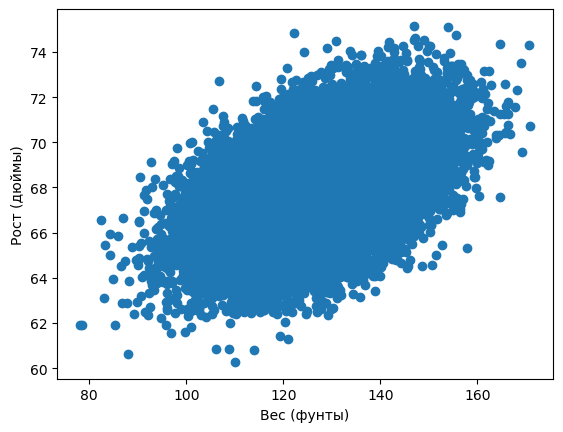

In [4]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Вес (фунты)")
plt.ylabel("Рост (дюймы)");

In [5]:
X, y = data_demo["Weight"].values, data_demo["Height"].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [8]:
regressor = SGDRegressor(eta=1e-3, n_iter=3)
regressor

SGDRegressor(eta=0.001, n_iter=3)

In [9]:
%%time

regressor.fit(X_train_scaled, y_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.65s/it]

CPU times: total: 17.9 s
Wall time: 17 s


SGDRegressor(eta=0.001, n_iter=3)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

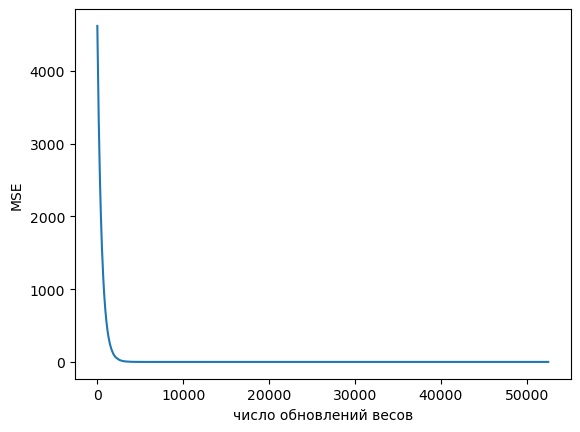

In [10]:
plt.plot(range(len(regressor.mse_)), regressor.mse_)
plt.xlabel("число обновлений весов")
plt.ylabel("MSE");

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [11]:
print(f"Наименьший MSE: {np.min(regressor.mse_)}")
print(f"Лучший вектор весов модели: {regressor.w_}")

Наименьший MSE: 2.7151352406643623
Лучший вектор весов модели: [67.9898497   0.94447605]


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

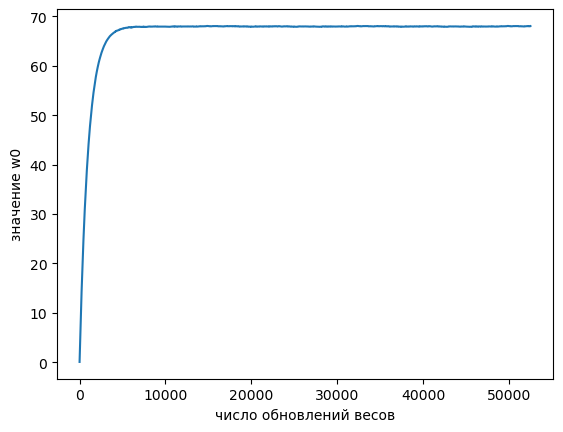

In [12]:
plt.plot(range(len(regressor.weights_)), [w[0] for w in regressor.weights_])
plt.xlabel("число обновлений весов")
plt.ylabel("значение w0");

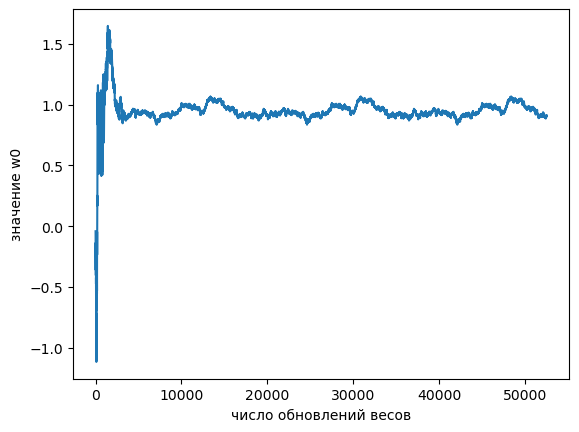

In [13]:
plt.plot(range(len(regressor.weights_)), [w[1] for w in regressor.weights_]);
plt.xlabel("число обновлений весов")
plt.ylabel("значение w0");

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [14]:
pred = regressor.predict(X_valid_scaled)
mean_squared_error(y_valid, pred)

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [15]:
lr = LinearRegression()

In [16]:
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [17]:
pred = lr.predict(X_valid_scaled)
mean_squared_error(y_valid, pred)

2.670830767667635

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5

**Ответ:** 5

## 2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

**Ответ:** 4 *(нужно взять производную от данной формулы по $w$, по итогу получим эту формулу)*

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [18]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1.0 / (1 + np.exp(-z))

In [118]:
class SGDClassifier(BaseEstimator):
    def __init__(self, eta: int, n_iter: int, C: float):
        self.eta = eta
        self.n_iter = n_iter
        self.C = C
        self.loss_ = list()
        self.weights_ = list()
        self.w_ = None
        
    def add_bias_column(self, X: np.array) -> np.array:
        return np.hstack([np.ones((X.shape[0], 1), dtype=X.dtype), X])
        
    def fit(self, X: np.array, y: np.array):
        X = self.add_bias_column(X)
        n_objects = X.shape[0]
        n_features = X.shape[1]
        w = np.zeros(n_features)
        
        for iteration in tqdm(range(self.n_iter)):
            for ob_idx in range(n_objects):
                new_w = w.copy()        
                sigma_value = sigma(-y[ob_idx] * np.dot(X[ob_idx, :], w))
                new_w[0] += self.eta * sigma_value
                
                for w_idx in range(0, n_features):
                    new_w[w_idx] += self.eta * (self.C * y[ob_idx] * X[ob_idx, w_idx] * sigma_value - w[w_idx])
                
                w = new_w.copy()
                running_loss = log_loss(y, sigma(np.dot(X, w)))
        
                self.weights_.append(w)
                self.loss_.append(running_loss)
                
        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self
               
    def predict_proba(self, X: np.array) -> np.array:
        X = self.add_bias_column(X)
        return sigma(np.dot(X, self.w_))
    
    def predict (self, X: np.array) -> np.array:
        threshold = 0.5
        preds = self.predict_proba(X)
        preds[preds > threshold] = 1
        preds[preds < threshold] = -1
        return preds

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [119]:
from sklearn.datasets import load_breast_cancer

In [120]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [121]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [122]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [123]:
classifier = SGDClassifier(eta=0.001, n_iter=3, C=1)

In [124]:
classifier.fit(X_train_scaled, y_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


SGDClassifier(C=1, eta=0.001, n_iter=3)

Постройте график изменения log_loss.

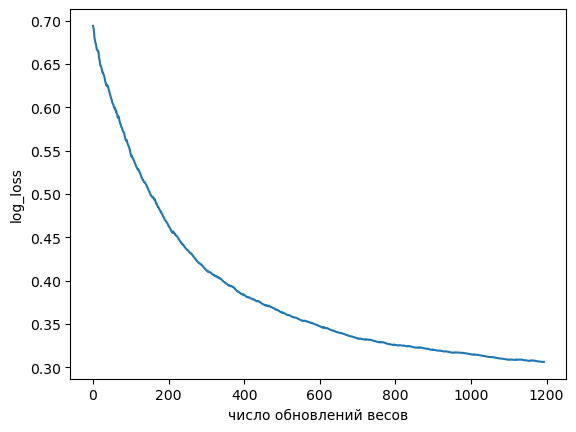

In [125]:
plt.plot(range(len(classifier.loss_)), classifier.loss_)
plt.xlabel("число обновлений весов")
plt.ylabel("log_loss");

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [126]:
classifier = SGDClassifier(eta=1e-3, n_iter=10, C=1000)
classifier.fit(X_train_scaled, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.92it/s]


SGDClassifier(C=1000, eta=0.001, n_iter=10)

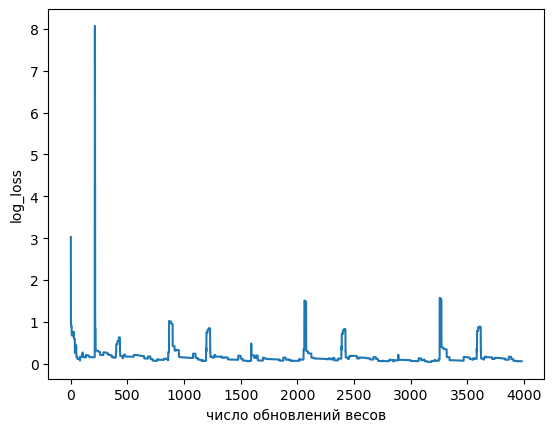

In [127]:
plt.plot(range(len(classifier.loss_)), classifier.loss_)
plt.xlabel("число обновлений весов")
plt.ylabel("log_loss");

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

Вектор весов длинее, т.к. мы добавляли слева столбец единиц

In [128]:
cancer.feature_names[np.argmin(classifier.w_[1:])]

'worst concavity'

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension
 - radius error

**Ответ:** worst concavity

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [129]:
preds = classifier.predict(X_valid_scaled)

In [130]:
log_loss(y_valid, preds), roc_auc_score(y_valid, preds)

(1.0539079938338352, 0.959016393442623)

In [56]:
lr = LogisticRegression(random_state=17)
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=17)

In [57]:
lr_preds = lr.predict(X_valid_scaled)

In [58]:
log_loss(y_valid, lr_preds), roc_auc_score(y_valid, lr_preds)

(0.8431263950670681, 0.9672131147540984)

Вывод: sklearn.linear_model.LogisticRegression имеет лучшие результат: меньше ошибка, и больше значение ROC AUC

## 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://drive.google.com/open?id=1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [440]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [443]:
import tarfile
import os
import requests
from io import BytesIO

# Download the dataset if not already in place

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


def load_imdb_dataset(extract_path="../data", overwrite=False):
    # check if existed already
    if (
        os.path.isfile(os.path.join(extract_path, "aclImdb", "README"))
        and not overwrite
    ):
        print("IMDB dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    tar = tarfile.open(mode="r:gz", fileobj=BytesIO(response.content))

    data = tar.extractall(extract_path)


load_imdb_dataset()

In [444]:
PATH_TO_IMDB = "../data/aclImdb"

reviews_train = load_files(
    os.path.join(PATH_TO_IMDB, "train"), categories=["pos", "neg"]
)

text_train, y_train = reviews_train.data, reviews_train.target

In [445]:
print("Число записей в тренировочных данных: %d" % len(text_train))
print(np.bincount(y_train))

Число записей в тренировочных данных: 25000
[12500 12500]


In [446]:
reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"), categories=["pos", "neg"])
text_test, y_test = reviews_test.data, reviews_test.target

In [447]:
print("Число записей в тестовых данных: %d" % len(text_test))
print(np.bincount(y_test))

Число записей в тестовых данных: 25000
[12500 12500]


Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [448]:
%%time

cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: total: 23.5 s
Wall time: 23.5 s


In [449]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [455]:
%%time

lr = LogisticRegression(random_state=17, max_iter=100)
lr.fit(X_train, y_train)

CPU times: total: 35.8 s
Wall time: 29.9 s


C:\Users\Acer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=17)

In [456]:
print(f"ROC AUC score: {roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])}")

ROC AUC score: 0.9577014272


Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)


**Ответ:**

 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - Есть распараллеливание по процессорам
 - Можно обучать LASSO
 - Поддерживается mini-batch подход (обновление весов по нескольким объектам сразу, а не по одному)

Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [461]:
%%time

clf = SGDClassifier(loss='log_loss', max_iter=100, random_state=17)
clf.fit(X_train, y_train)

CPU times: total: 1.19 s
Wall time: 1.2 s


SGDClassifier(loss='log_loss', max_iter=100, random_state=17)

Обучение было в ~15 раз быстрее

In [464]:
print(f"ROC AUC score: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}")

ROC AUC score: 0.9529982944


<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - 3
 - 4
 - 5

**Ответ:** 3